## Heart failure prediction using ANN

Import libraries

In [623]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Libraries for ANN
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LSTM
from keras.callbacks import EarlyStopping


Load data

In [624]:
data = pd.read_csv("heart_failure_clinical_records_dataset.csv")
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


### Data Preperation

In [625]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


check missing values

In [626]:
data.isnull().sum() # No missing value

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

check outliers

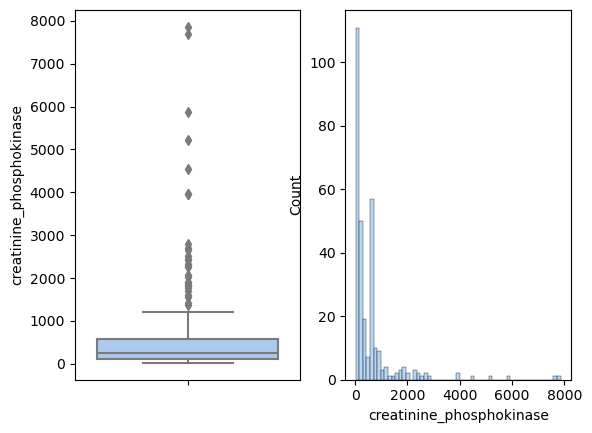

True    270
Name: cp_non_outliers, dtype: int64

In [627]:
# Visualising outliers for "creatinine_phosphokinase"
figure, ax = plt.subplots(1, 2, squeeze = False)
sns.boxplot(ax = ax[0,0], y = data["creatinine_phosphokinase"])
sns.histplot(ax = ax[0,1], x = data["creatinine_phosphokinase"])
sns.set_palette("pastel")
plt.show()

# Defining Outliers
Q1 = data["creatinine_phosphokinase"].quantile(0.25)
Q3 = data["creatinine_phosphokinase"].quantile(0.75)
IQR = Q3 - Q1    # IQR is interquartile range
outlier_ll = Q1 - 1.5 * IQR
outlier_ul = Q3 + 1.5 * IQR

# Counting Outliers
non_outliers = (data["creatinine_phosphokinase"] >= outlier_ll) & (data["creatinine_phosphokinase"] <= outlier_ul)
non_outliers.value_counts() # True = 270, False = 28
data["cp_non_outliers"] = non_outliers

# Drop rows of ouliers for "creatinine_phosphokinase" column
data.drop(data[data["cp_non_outliers"] == False].index, axis = 0, inplace = True)
# Checking
data["cp_non_outliers"].value_counts() # True = 270

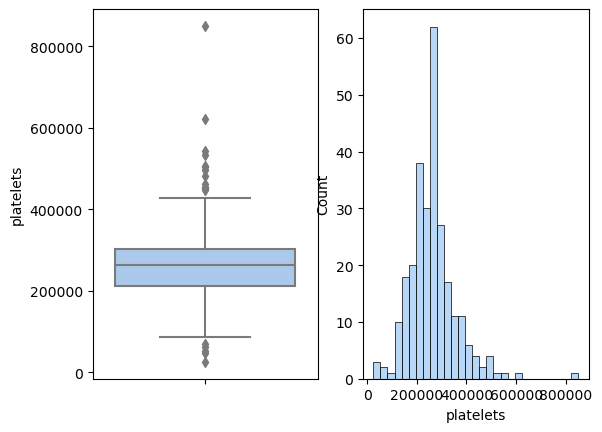

543000.0

In [628]:
# Visualising outliers for "platelets"
figure, ax = plt.subplots(1, 2, squeeze = False)
sns.boxplot(ax = ax[0,0], y = data["platelets"])
sns.histplot(ax = ax[0,1], x = data["platelets"])
plt.show()

# Drop rows of 2 ouliers for "platelets" column
data.drop(data[data["platelets"] > 600000].index, axis = 0, inplace = True)
data["platelets"].max()

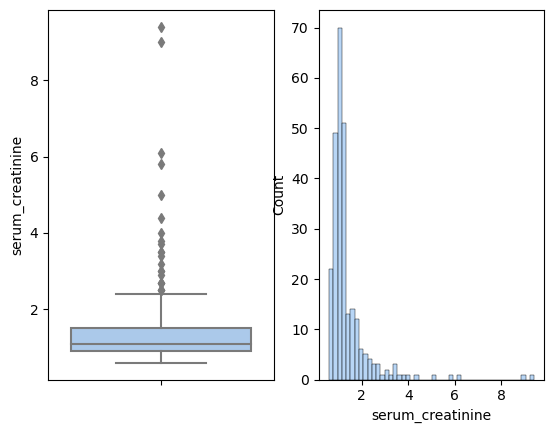

4.4

In [629]:
# Visualising outliers for "serum_creatinine"
figure, ax = plt.subplots(1, 2, squeeze = False)
sns.boxplot(ax = ax[0,0], y = data["serum_creatinine"])
sns.histplot(ax = ax[0,1], x = data["serum_creatinine"])
plt.show()

# Drop rows of ouliers above 5 for "serum_creatinine" column
data.drop(data[data["serum_creatinine"] >= 5].index, axis = 0, inplace = True)
data["serum_creatinine"].max()

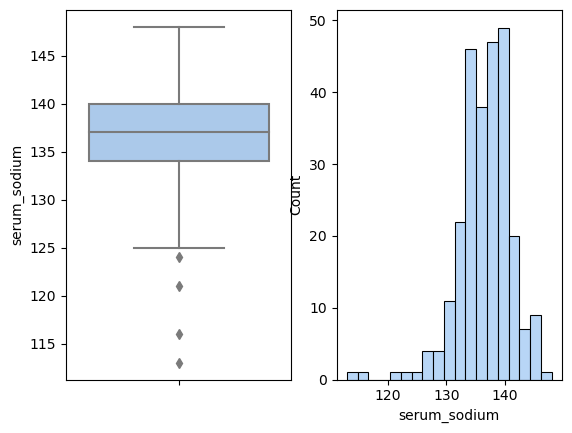

134

In [630]:
# Visualising outliers for "serum_sodium"
figure, ax = plt.subplots(1, 2, squeeze = False)
sns.boxplot(ax = ax[0,0], y = data["serum_sodium"])
sns.histplot(ax = ax[0,1], x = data["serum_sodium"])
plt.show()

# Drop rows of ouliers for "serum_sodium" column
data.drop(data[data["serum_sodium"] < 134].index, axis = 0, inplace = True)
data["serum_sodium"].min()

In [631]:
# Dropping time and cp_non_outliers column
data.drop("time", axis = 1, inplace = True)
data.drop("cp_non_outliers", axis = 1, inplace = True)
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,1
8,65.0,0,157,0,65,0,263358.03,1.5,138,0,0,1
11,62.0,0,231,0,25,1,253000.00,0.9,140,1,1,1
12,45.0,1,981,0,30,0,136000.00,1.1,137,1,0,1


### Data Visualisations

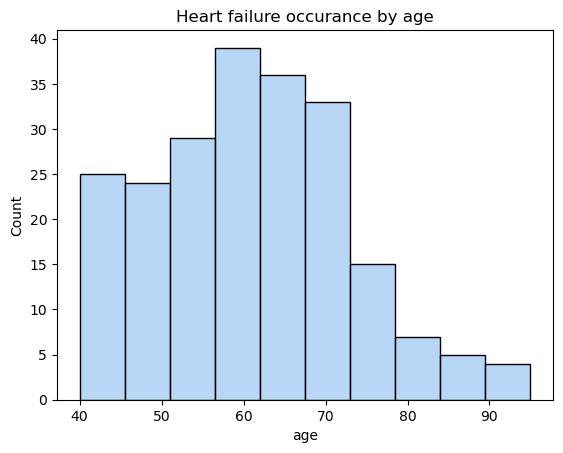

In [632]:
# Heart failure occurance by age
sns.histplot(data = data, x = data["age"])
plt.title("Heart failure occurance by age")
plt.show()

# Late 50s to early 70s are most frequent

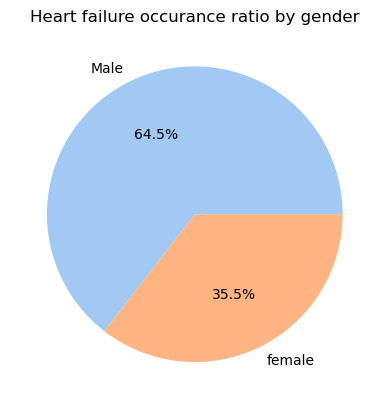

In [633]:
# Heart failure occurance ratio by gender
plt.pie(data["sex"].value_counts(), labels = ["Male", "female"], autopct = "%1.1f%%")
plt.title("Heart failure occurance ratio by gender")
plt.show()

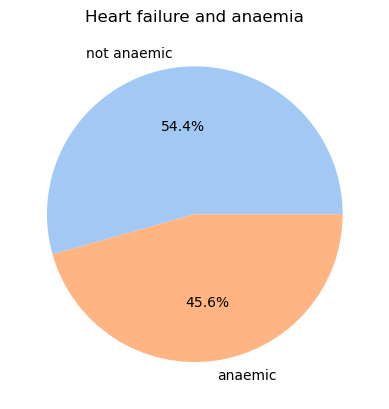

In [634]:
# Heart failure and anaemia
plt.pie(data["anaemia"].value_counts(), labels = ["not anaemic", "anaemic"], autopct = "%1.1f%%")
plt.title("Heart failure and anaemia")
plt.show()

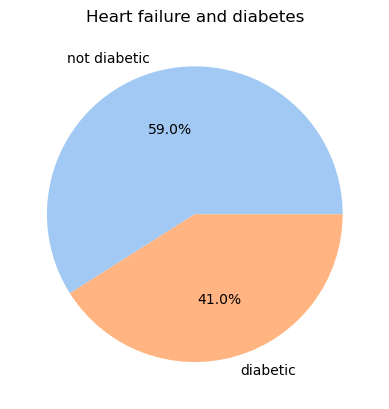

In [635]:
# Heart failure and diabetes
plt.pie(data["diabetes"].value_counts(), labels = ["not diabetic", "diabetic"], autopct = "%1.1f%%")
plt.title("Heart failure and diabetes")
plt.show()

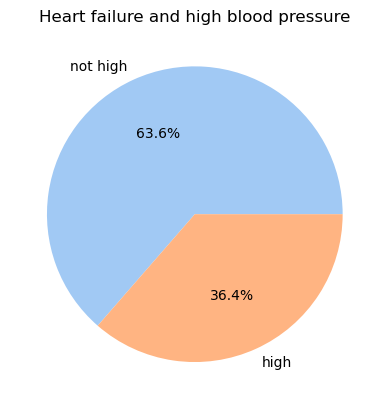

In [636]:
# Heart failure and high blood pressure
plt.pie(data["high_blood_pressure"].value_counts(), labels = ["not high", "high"], autopct = "%1.1f%%")
plt.title("Heart failure and high blood pressure")
plt.show()

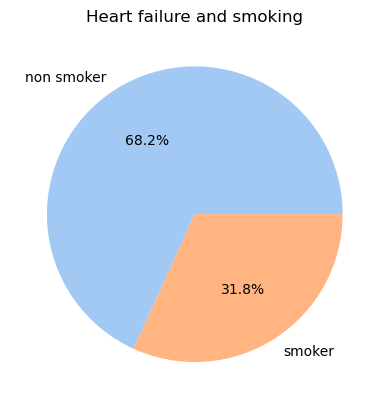

In [637]:
# Heart failure and smoking
plt.pie(data["smoking"].value_counts(), labels = ["non smoker", "smoker"], autopct = "%1.1f%%")
plt.title("Heart failure and smoking")
plt.show()

### ANN

Define X and y

In [638]:
X = data.drop("DEATH_EVENT", axis = 1)
y = data["DEATH_EVENT"]

Fit X to StandardScaler

In [639]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Splitting data into train and test

In [640]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [641]:
# Stop training once train performance improvement stops
early_stopping = EarlyStopping(
    min_delta = 0.001,
    patience = 20,
    restore_best_weights = True)


# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 22, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))
model.add(Dense(units = 11, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 11, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))


# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 20, epochs = 100, callbacks = [early_stopping], validation_split = 0.2)

Epoch 1/100


/Users/ayakobland/miniforge3/lib/python3.10/site-packages/keras/engine/data_adapter.py:1508: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-11-18 13:07:37.396107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.6884

2022-11-18 13:07:38.693682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 2s 172ms/step - loss: 0.6926 - accuracy: 0.6884 - val_loss: 0.6909 - val_accuracy: 0.8000
Epoch 2/100
7/7 [==============================] - 0s 21ms/step - loss: 0.6912 - accuracy: 0.6884 - val_loss: 0.6887 - val_accuracy: 0.8000
Epoch 3/100
7/7 [==============================] - 0s 29ms/step - loss: 0.6898 - accuracy: 0.6884 - val_loss: 0.6864 - val_accuracy: 0.8000
Epoch 4/100
7/7 [==============================] - 0s 39ms/step - loss: 0.6883 - accuracy: 0.6884 - val_loss: 0.6838 - val_accuracy: 0.8000
Epoch 5/100
7/7 [==============================] - 0s 17ms/step - loss: 0.6866 - accuracy: 0.6884 - val_loss: 0.6811 - val_accuracy: 0.8000
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 0.6848 - accuracy: 0.6884 - val_loss: 0.6779 - val_accuracy: 0.8000
Epoch 7/100
7/7 [==============================] - 0s 14ms/step - loss: 0.6819 - accuracy: 0.6884 - val_loss: 0.6744 - val_accuracy: 0.8000
Epoch 8/100
7/7 [==============

Training and Validation Loss 

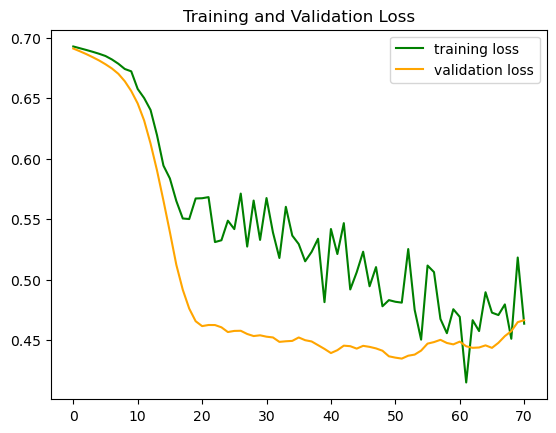

In [642]:
plt.plot(history.history["loss"], label = "training loss", color = "green")
plt.plot(history.history["val_loss"], label = "validation loss", color = "orange")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Training and Validation Accuracy

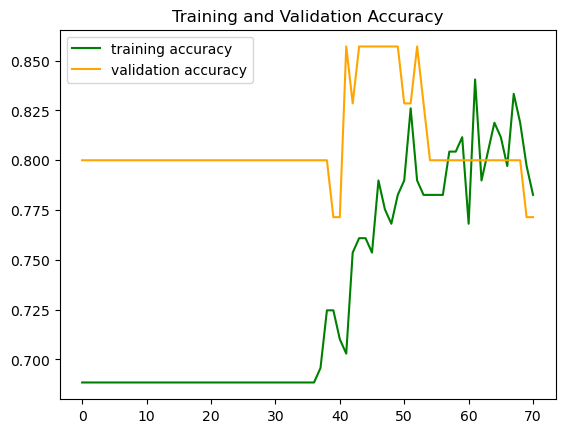

In [643]:
plt.plot(history.history["accuracy"], label = "training accuracy", color = "green")
plt.plot(history.history["val_accuracy"], label = "validation accuracy", color = "orange")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

Predict the test set

In [644]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.4)

2/2 [==============================] - 0s 80ms/step


2022-11-18 13:07:45.209829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [645]:
# results in dataframe
y_pred = y_pred.flatten()
y_pred = pd.Series(y_pred, name = "Prediction")
y_test = y_test.reset_index()
y_pred = pd.DataFrame(y_pred)
y_test = y_test.drop("index", axis = 1)
result = pd.concat([y_test, y_pred], axis = 1)
result

,DEATH_EVENT,Prediction
0,0,False
1,0,True
2,0,False
3,0,False
4,0,True
5,0,False
6,0,False
7,1,False
8,0,False
9,0,False


Confusion Matrix

In [646]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[28,  5],
       [ 8,  3]])

Classification Report

In [647]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81        33
           1       0.38      0.27      0.32        11

    accuracy                           0.70        44
   macro avg       0.58      0.56      0.56        44
weighted avg       0.68      0.70      0.69        44

